In [10]:
import os
import cv2
import csv
import random
import numpy as np
import pandas as pd
import seaborn as sns
# from google.colab import drive
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from IPython.display import Image as IPImage
from collections import Counter
import json
import torch
import itertools
from tqdm import tqdm
import torchvision
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import ImageFolder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report

In [11]:
import warnings
# to ignore unnecessary warnings in the notebook output
warnings.filterwarnings('ignore')

# setting seed to reproduce the model performance
torch.manual_seed(42)

In [12]:
extracted_files_dir = 'extracted_images\\'
extracted_files = os.listdir(extracted_files_dir)
print(f"Extracted folders and files: {extracted_files}")

Extracted folders and files: ['test_1', 'test_2', 'train_1', 'train_2', 'train_3', 'train_4', 'train_5', 'train_6', 'unseen_data', 'validation_1', 'validation_2']


#### **Dataset**
The dataset which we have chosen is from Kaggle which is a [Celeb Face Attributes dataset](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/data), the dataset is annotated with around 40 attributes.



*   202,599 number of face images of various celebrities
*   10,177 unique identities, but names of identities are not given
*   40 binary attribute annotations per image such as Male, Attractiveness, Young etc,.
*   5 landmark locations such as left eye, mouth etc,.

**Data Files:**

list_eval_partition.csv     : Recommended partitioning of images into training, validation, testing sets.

list_bbox_celeba.csv        :  Bounding box information for each image.

list_landmarks_align_celeba.csv: Image landmarks and their respective coordinates.

list_attr_celeba.csv        : Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative.


In [13]:
# setting all the folders and files to it's respective variables for using it later on!
eval_partition_file = "list_eval_partition.csv"
bbox_celeb_file = "list_bbox_celeba.csv"
landmarks_celeb_file = "list_landmarks_align_celeba.csv"
attr_celebs_file = "list_attr_celeba.csv"

celeb_imgs_file = "extracted_images\\"

In [14]:
# reading celeb face attributes file
celeb_attr = pd.read_csv(attr_celebs_file)
new_column_names = [col.replace('_', ' ') if col != 'image_id' else col for col in celeb_attr.columns]
celeb_attr.columns = new_column_names
celeb_attr.head()

,image_id,5 o Clock Shadow,Arched Eyebrows,Attractive,Bags Under Eyes,Bald,Bangs,Big Lips,Big Nose,Black Hair,...,Sideburns,Smiling,Straight Hair,Wavy Hair,Wearing Earrings,Wearing Hat,Wearing Lipstick,Wearing Necklace,Wearing Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [15]:
celeb_attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   image_id             202599 non-null  object
 1   5 o Clock Shadow     202599 non-null  int64 
 2   Arched Eyebrows      202599 non-null  int64 
 3   Attractive           202599 non-null  int64 
 4   Bags Under Eyes      202599 non-null  int64 
 5   Bald                 202599 non-null  int64 
 6   Bangs                202599 non-null  int64 
 7   Big Lips             202599 non-null  int64 
 8   Big Nose             202599 non-null  int64 
 9   Black Hair           202599 non-null  int64 
 10  Blond Hair           202599 non-null  int64 
 11  Blurry               202599 non-null  int64 
 12  Brown Hair           202599 non-null  int64 
 13  Bushy Eyebrows       202599 non-null  int64 
 14  Chubby               202599 non-null  int64 
 15  Double Chin          202599 non-nu

In [17]:
# reading evaluation partion file
eval_partition = pd.read_csv(eval_partition_file)
eval_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [18]:
# reading landmark align celeb file
landmarks_celeb = pd.read_csv(landmarks_celeb_file)
landmarks_celeb.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150


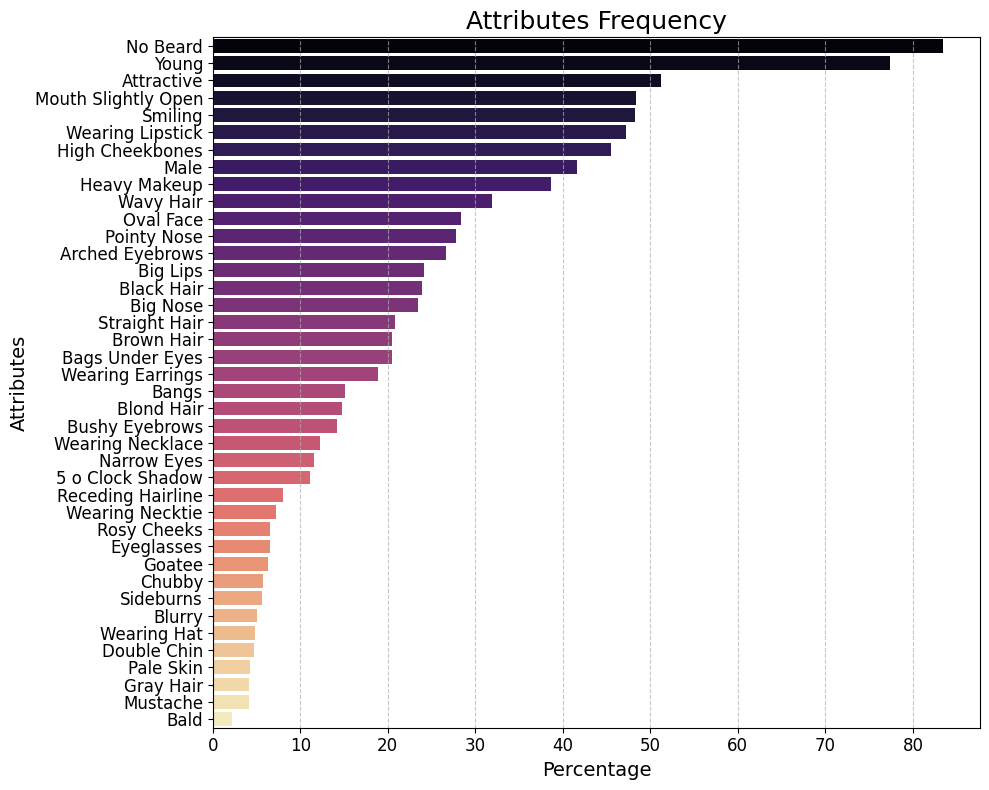

In [19]:
celeb_attr = celeb_attr.replace(to_replace=-1, value=0)

# summing up attribute counts
attr_counts = celeb_attr.loc[:, celeb_attr.columns != "image_id"].sum()

# calculate the percentages
perc = (attr_counts / celeb_attr.shape[0]) * 100

# sorting attributes by percentage in descending order
percent_sorted = perc.sort_values(ascending=False)

# plotting the graph
plt.figure(figsize=(10, 8))
sns.barplot(x=percent_sorted.values, y=percent_sorted.index, palette='magma')
plt.title('Attributes Frequency', fontsize=18)
plt.xlabel('Percentage', fontsize=14)
plt.ylabel('Attributes', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

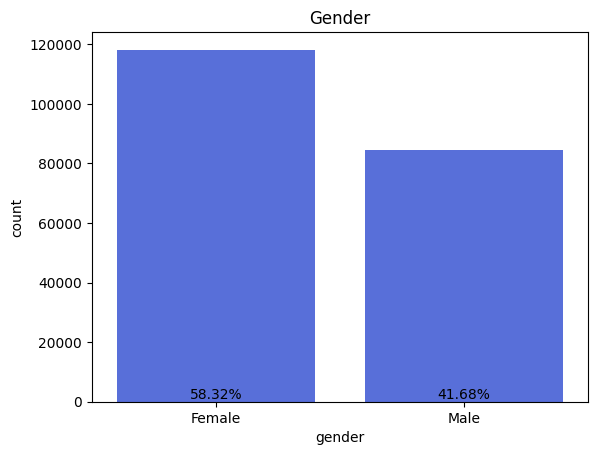

In [20]:
# Focusing only on Gender distribution
gender_attr = celeb_attr['Male']
gender_attr = gender_attr.to_frame()

gender_attr.columns = ['gender']
gender_attr = gender_attr.replace(to_replace=1, value='Male')
gender_attr = gender_attr.replace(to_replace=0, value='Female')
male_perc = ((gender_attr['gender'] == 'Male').sum() / gender_attr.shape[0]) * 100
female_perc = ((gender_attr['gender'] == 'Female').sum() / gender_attr.shape[0]) * 100

plt.title('Gender')
sns.countplot(x='gender', data=gender_attr, color="#4361EE")
plt.text(1, male_perc, f'{male_perc:.2f}%', ha='center', va='bottom')
plt.text(0, female_perc, f'{female_perc:.2f}%', ha='center', va='bottom')
plt.show()

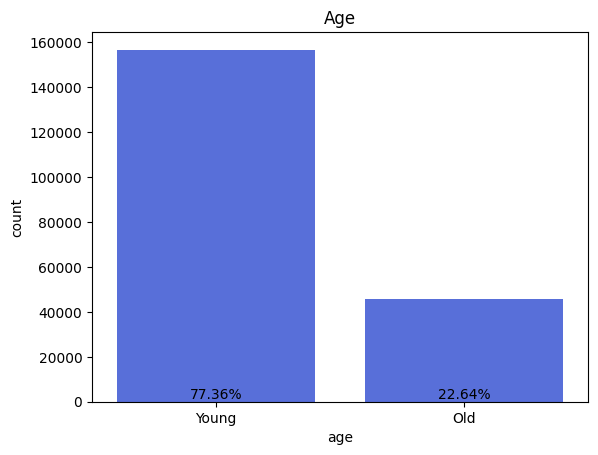

In [21]:
# Focusing only on Age distribution
age_attr = celeb_attr['Young']
age_attr = age_attr.to_frame()

age_attr.columns = ['age']
age_attr = age_attr.replace(to_replace=1, value='Young')
age_attr = age_attr.replace(to_replace=0, value='Old')
young_perc = ((age_attr['age'] == 'Young').sum() / age_attr.shape[0]) * 100
old_perc = ((age_attr['age'] == 'Old').sum() / age_attr.shape[0]) * 100

plt.title('Age')
sns.countplot(x='age', data=age_attr, color="#4361EE")
plt.text(0, young_perc, f'{young_perc:.2f}%', ha='center', va='bottom')
plt.text(1, old_perc, f'{old_perc:.2f}%', ha='center', va='bottom')
plt.show()

In [22]:
def plotCorrelationMatrix(df, graphWidth):
    """Plot correlation matrix heatmap for the given DataFrame.

    Args:
        df (DataFrame): DataFrame containing the data.
        graphWidth (int): Width of the plot in inches.
    """
    df = df[[col for col in df if df[col].nunique() > 1]]
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.show()

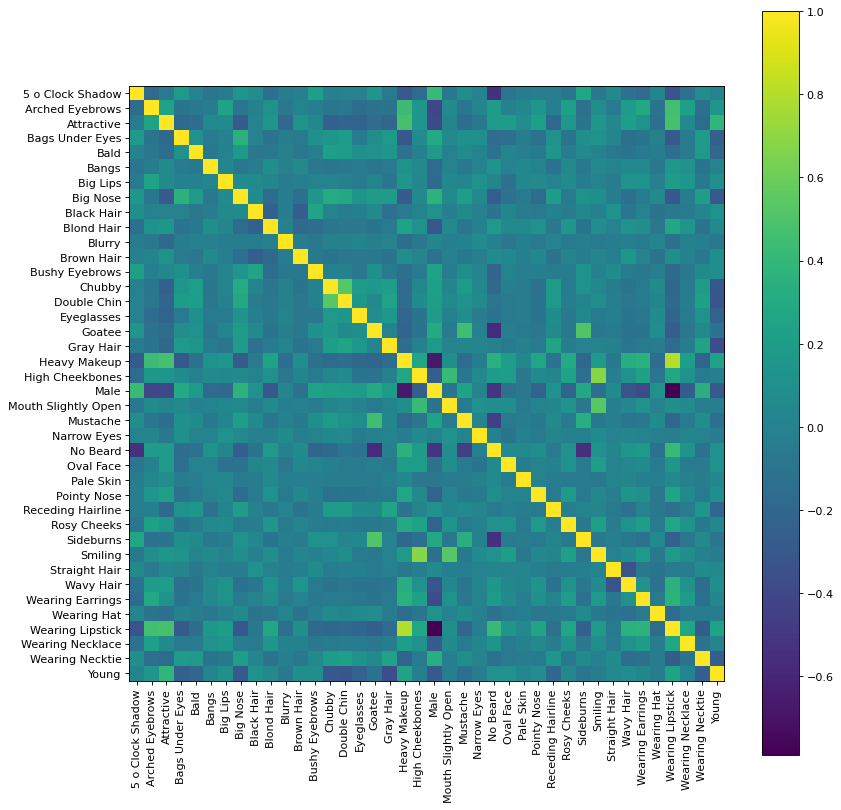

In [23]:
# correlation Matrix
plotCorrelationMatrix(celeb_attr.loc[:, celeb_attr.columns != 'image_id'], 12)

We can identify that we can group some of the features into one single and and encode those as per each feature.

Dimensionality Reduction

PS: Is it necessary?

### **Modeling and Evaluation**

In [24]:
# Reading evaluation parameters and labels
eval_imgs = eval_partition['image_id'].values
eval_val = eval_partition['partition'].values
labels = celeb_attr.loc[:, celeb_attr.columns != 'image_id'].values

eval_pars = dict(eval_partition['partition'].value_counts())
print(eval_pars)
# 0 - train
# 1 - validation
# 2 - test

train_idx = eval_pars[0]
val_idx = eval_pars[1]
test_idx = eval_pars[2]

{0: 162770, 2: 19962, 1: 19867}


In [25]:
# Taking only 40000 data train right now and 5000 data for validation and testing
train_st = 0
train_en = train_st + 40000
val_st = train_idx + 1
val_en = val_st + 5000
test_st = train_idx + val_idx + 1
test_en = test_st + 5000

In [26]:
def create_folders_and_paths(start_index, end_index, folder_prefix):
    """Create folder structure and paths for images and corresponding labels.

    Args:
        start_index (int): Starting index for image data.
        end_index (int): Ending index for image data.
        folder_prefix (str): Prefix for folder names.

    Returns:
        tuple: Tuple containing lists of image paths and corresponding labels.
    """
    idx = 1
    imgs = []
    label = []
    # iterating over the range of indices
    for i in range(start_index, end_index, 10000):
        # creating folder path based on index and prefix
        folder_path = os.path.join(celeb_imgs_file, f"{folder_prefix}_{idx}")
        # checking if there are more than 10,000 images left
        if end_index - i >= 10000:
            # creating image paths for 10,000 images
            img_paths = list(map(lambda name: os.path.join(folder_path, name), eval_imgs[i:i+9999]))
            imgs.extend(img_paths)
            label.extend(labels[i:i+9999])
        else:
            # creating image paths for remaining images
            img_paths = list(map(lambda name: os.path.join(folder_path, name), eval_imgs[i:end_index]))
            imgs.extend(img_paths)
            label.extend(labels[i:end_index])
        idx += 1
    return imgs, label

# generating paths for train, validation, and test data
train_imgs, train_labels = create_folders_and_paths(train_st, train_en, 'train')
validation_imgs, validation_labels = create_folders_and_paths(val_st, val_en, 'validation')
test_imgs, test_labels = create_folders_and_paths(test_st, test_en, 'test')

print(len(train_imgs))
print(len(train_labels))

39996
39996


In [27]:
# creating transformations that needs to be applied on the training, validation, testing data respectively
train_transform = transforms.Compose([transforms.Resize((64, 64)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor(),
                                      # the mean ans std are  derived from the ImageNet dataset, which is often used for pre-training deep learning models
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

validation_transform = transforms.Compose([transforms.Resize((64, 64)),
                                           transforms.RandomHorizontalFlip(p=0.75),
                                           transforms.ToTensor(),
                                           # the mean ans std are  derived from the ImageNet dataset, which is often used for pre-training deep learning models
                                           transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

test_transform = transforms.Compose([transforms.Resize((64, 64)),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     # the mean ans std are  derived from the ImageNet dataset, which is often used for pre-training deep learning models
                                     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [28]:
# getting classes and reading images and it's corresponding labels or classes
def get_class(celeb_attr):
    """Get list of classes from the celebrity attribute DataFrame.

    Args:
        celeb_attr (DataFrame): DataFrame containing celebrity attributes.

    Returns:
        list: List of classes.
    """
    classes = celeb_attr.loc[:, celeb_attr.columns != 'image_id'].columns.to_list()
    return classes

def celeb_dataset(img_paths, labels, transform=None):
    """Create dataset containing images and corresponding labels.

    Args:
        img_paths (list): List of image file paths.
        labels (list): List of labels or classes corresponding to images.
        transform (callable, optional): Optional transform to be applied on images.

    Returns:
        list: List of dictionaries containing image and label pairs.
    """
    img_and_labels = [(img_path, label) for img_path, label in zip(img_paths, labels)]
    img_dataset = []
    cnt = 0
    print("Process started!")
    for img_path, label in img_and_labels:
        image = PILImage.open(img_path).convert('RGB')
        if transform:
            image = transform(image)
        img_dataset.append({'image': image, 'label': torch.Tensor(label)})
        cnt = cnt + 1
        if cnt % 500 == 0:
            print(f"Processed {cnt} images")
    return img_dataset

In [29]:
print(torch.cuda.is_available()) # where cuda can be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

True
cuda


In [30]:
class GetCelebDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        """Dataset class for celebrity images.

        Args:
            data (list): List of image file paths.
            labels (list): List of labels or classes corresponding to images.
            transform (callable, optional): Optional transform to be applied on images.
        """
        self.data = data
        self.labels = labels
        self.transform = transform
        self.classes = get_class(celeb_attr)

    def __len__(self):
        """Get the length of the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """Get item from dataset by index.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            dict: Dictionary containing image and label.
        """
        image = PILImage.open(self.data[idx]).convert('RGB')
        label = torch.Tensor(self.labels[idx])
        if self.transform:
            image = self.transform(image)
            sample = {'image': image, 'label': label}
        else:
            sample = {'image': image, 'label': label}
        return sample


In [31]:
# Getting the train, val and test datasets
train_dataset = GetCelebDataset(train_imgs, train_labels, train_transform)
val_dataset = GetCelebDataset(validation_imgs, validation_labels, validation_transform)
test_dataset = GetCelebDataset(test_imgs, test_labels, test_transform)

In [32]:
# Training data statistics
print(f"Total number of training images in the dataset: {len(train_dataset)}")
print(f"Shape of a sample image: {train_dataset[0]['image'].shape}")
print(f"Shape of a sample image is {train_dataset[15]['image'].shape} and it's class value is {train_dataset[15]['label']}")
print(f"List of the classes: {train_dataset.classes}")

Total number of training images in the dataset: 39996
Shape of a sample image: torch.Size([3, 64, 64])
Shape of a sample image is torch.Size([3, 64, 64]) and it's class value is tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 1.])
List of the classes: ['5 o Clock Shadow', 'Arched Eyebrows', 'Attractive', 'Bags Under Eyes', 'Bald', 'Bangs', 'Big Lips', 'Big Nose', 'Black Hair', 'Blond Hair', 'Blurry', 'Brown Hair', 'Bushy Eyebrows', 'Chubby', 'Double Chin', 'Eyeglasses', 'Goatee', 'Gray Hair', 'Heavy Makeup', 'High Cheekbones', 'Male', 'Mouth Slightly Open', 'Mustache', 'Narrow Eyes', 'No Beard', 'Oval Face', 'Pale Skin', 'Pointy Nose', 'Receding Hairline', 'Rosy Cheeks', 'Sideburns', 'Smiling', 'Straight Hair', 'Wavy Hair', 'Wearing Earrings', 'Wearing Hat', 'Wearing Lipstick', 'Wearing Necklace', 'Wearing Necktie', 'Young']


In [33]:
# Validation data statistics
print(f"Total number of validation images in the dataset: {len(val_dataset)}")
print(f"Shape of a sample image: {val_dataset[10]['image'].shape}")
print(f"Shape of a sample image is {val_dataset[30]['image'].shape} and it's class value is {val_dataset[30]['label']}")
print(f"List of the classes: {val_dataset.classes}")

Total number of validation images in the dataset: 5000
Shape of a sample image: torch.Size([3, 64, 64])
Shape of a sample image is torch.Size([3, 64, 64]) and it's class value is tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 1.])
List of the classes: ['5 o Clock Shadow', 'Arched Eyebrows', 'Attractive', 'Bags Under Eyes', 'Bald', 'Bangs', 'Big Lips', 'Big Nose', 'Black Hair', 'Blond Hair', 'Blurry', 'Brown Hair', 'Bushy Eyebrows', 'Chubby', 'Double Chin', 'Eyeglasses', 'Goatee', 'Gray Hair', 'Heavy Makeup', 'High Cheekbones', 'Male', 'Mouth Slightly Open', 'Mustache', 'Narrow Eyes', 'No Beard', 'Oval Face', 'Pale Skin', 'Pointy Nose', 'Receding Hairline', 'Rosy Cheeks', 'Sideburns', 'Smiling', 'Straight Hair', 'Wavy Hair', 'Wearing Earrings', 'Wearing Hat', 'Wearing Lipstick', 'Wearing Necklace', 'Wearing Necktie', 'Young']


In [34]:
# Testing data statistics
print(f"Total number of tesitng images in the dataset: {len(test_dataset)}")
print(f"Shape of a sample image: {test_dataset[10]['image'].shape}")
print(f"Shape of a sample image is {test_dataset[35]['image'].shape} and it's class value is {test_dataset[35]['label']}")
print(f"List of the classes: {test_dataset.classes}")

Total number of tesitng images in the dataset: 5000
Shape of a sample image: torch.Size([3, 64, 64])
Shape of a sample image is torch.Size([3, 64, 64]) and it's class value is tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 1.])
List of the classes: ['5 o Clock Shadow', 'Arched Eyebrows', 'Attractive', 'Bags Under Eyes', 'Bald', 'Bangs', 'Big Lips', 'Big Nose', 'Black Hair', 'Blond Hair', 'Blurry', 'Brown Hair', 'Bushy Eyebrows', 'Chubby', 'Double Chin', 'Eyeglasses', 'Goatee', 'Gray Hair', 'Heavy Makeup', 'High Cheekbones', 'Male', 'Mouth Slightly Open', 'Mustache', 'Narrow Eyes', 'No Beard', 'Oval Face', 'Pale Skin', 'Pointy Nose', 'Receding Hairline', 'Rosy Cheeks', 'Sideburns', 'Smiling', 'Straight Hair', 'Wavy Hair', 'Wearing Earrings', 'Wearing Hat', 'Wearing Lipstick', 'Wearing Necklace', 'Wearing Necktie', 'Young']


In [35]:
def dataloader(batch_size, device):
    """Create data loaders for train, validation, and test datasets.

    Args:
        batch_size (int): Batch size for data loaders.
        device (torch.device): Device where the data will be loaded.

    Returns:
        tuple: Tuple containing train, validation, and test data loaders.
    """

    # Create data loaders for train, validation, and test datasets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [27]:
def generate_class_weights(class_series, class_labels):
    """Generate class weights based on the distribution of classes in the dataset.

    Args:
        class_series (list): List of class labels for each sample in the dataset.
        class_labels (list): List of unique class labels.

    Returns:
        dict: Dictionary containing class labels as keys and their corresponding weights.
    """
    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # initializing a list to store the count of each class
    class_count = [0] * n_classes
    # counting the occurrences of each class in the dataset
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1

    # calculating the class weights based on the class count
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights))
    return dict(zip(class_labels, class_weights))

In [28]:
# assigning class weights for further usage
class_weights = generate_class_weights(train_labels, train_dataset.classes)
class_weights

{0: 0.22560920577617327,
 1: 0.09444601870218192,
 2: 0.04860489986389267,
 3: 0.12291333743085434,
 4: 1.1012114537444935,
 5: 0.1624269005847953,
 6: 0.10433013355592655,
 7: 0.1053746443250079,
 8: 0.10391810434421118,
 9: 0.169302404334575,
 10: 0.47523764258555135,
 11: 0.12234185733512785,
 12: 0.17435047951176982,
 13: 0.43379609544468545,
 14: 0.5472906403940887,
 15: 0.3857638888888889,
 16: 0.39366141732283466,
 17: 0.5951785714285714,
 18: 0.06510189465459991,
 19: 0.05555925987664611,
 20: 0.059674146574361424,
 21: 0.052309704420612085,
 22: 0.613059472716125,
 23: 0.21369950844197477,
 24: 0.030006301953605617,
 25: 0.08903829029385574,
 26: 0.5809994189424753,
 27: 0.09098271155595997,
 28: 0.31712654614652713,
 29: 0.39135029354207435,
 30: 0.43816827344434706,
 31: 0.05250472589792061,
 32: 0.11947663998088183,
 33: 0.07842968075927524,
 34: 0.13417874396135265,
 35: 0.5060222672064777,
 36: 0.053265501811208184,
 37: 0.20663360198388098,
 38: 0.3383756345177665,
 39: 

##### **Defining the model**

In [29]:
def accuracy_score(y_true, y_pred):
    """Calculate accuracy score for multilabel classification.

    Args:
        y_true (list): List of true labels for each sample.
        y_pred (list): List of predicted labels for each sample.

    Returns:
        float: Accuracy score.
    """
    num_samples = len(y_true)
    total_correct = 0
    total_labels = 0

    # total correct predictions and total labels
    for true_labels, pred_labels in zip(y_true, y_pred):
        correct_labels = (true_labels == pred_labels).sum()
        total_correct += correct_labels
        total_labels += len(true_labels)

    accuracy = total_correct / total_labels
    return accuracy

def get_multilabel_evaluation(model, test_loader):
    """Evaluate a multilabel classification model on a test set.

    Args:
        model (torch.nn.Module): Multilabel classification model.
        test_loader (DataLoader): DataLoader containing the test set.

    Returns:
        tuple: Tuple containing lists of all predicted labels and true labels.
    """
    all_predictions = []
    all_targets = []
    model.eval()
    with torch.no_grad():
        for dir_ in test_loader:
            inputs, targets = dir_.values()
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            # outputs to binary predictions
            predictions = (outputs > 0.01).float()
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    return all_predictions, all_targets

In [30]:
def train_model(model, device, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    """Train a PyTorch model.

    Args:
        model (torch.nn.Module): Model to be trained.
        device (torch.device): Device where the model and data will be loaded.
        train_loader (DataLoader): DataLoader containing the training data.
        val_loader (DataLoader): DataLoader containing the validation data.
        criterion (torch.nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        num_epochs (int, optional): Number of epochs to train the model (default is 5).

    Returns:
        list: List containing training losses, training accuracy scores, validation losses, and validation accuracy scores.
    """
    train_losses = []
    train_accuracy_scores = []
    val_losses = []
    val_accuracy_scores = []

    # Iterate over epochs
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_train_loss = 0

        # Display progress using tqdm
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
        for dict_ in train_bar:
            inputs, labels = dict_.values()
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            predicted_labels = (outputs > 0.5).float()
            accuracy_score_value = accuracy_score(labels.cpu().numpy(), predicted_labels.cpu().numpy())
            train_bar.set_postfix(loss=loss.item(), accuracy_score=accuracy_score_value)

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy_scores.append(accuracy_score_value)

        model.eval()
        total_val_loss = 0

        # Validation phase
        with torch.no_grad():
            for dict_ in val_loader:
                inputs, labels = dict_.values()
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item() * inputs.size(0)

                predicted_labels = (outputs > 0.5).float()
                val_accuracy_score = accuracy_score(labels.cpu().numpy(), predicted_labels.cpu().numpy())

        val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy_scores.append(val_accuracy_score)

        # epoch-wise statistics
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train accuracy Score: {accuracy_score_value:.4f}, Val Loss: {val_loss:.4f}, Val accuracy Score: {val_accuracy_score:.4f}")

    return [train_losses, train_accuracy_scores, val_losses, val_accuracy_scores]

In [31]:
def define_model(train_loader, val_loader, test_loader, learning_rate, num_features, dropout_prob, device):
    """Define and train a model using transfer learning.

    Args:
        train_loader (DataLoader): DataLoader containing the training data.
        val_loader (DataLoader): DataLoader containing the validation data.
        test_loader (DataLoader): DataLoader containing the test data.
        learning_rate (float): Learning rate for the optimizer.
        num_features (int): Number of features in the final fully connected layer.
        dropout_prob (float): Dropout probability for regularization.
        device (torch.device): Device where the model and data will be loaded.

    Returns:
        tuple: Tuple containing the trained model and evaluation metrics.
    """
    Model = resnet50(weights=ResNet50_Weights.DEFAULT)

    # Modify the final fully connected layer
    Model.fc = nn.Sequential(
        nn.Linear(Model.fc.in_features, num_features),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_prob),
        nn.Linear(num_features, len(train_dataset.classes))
    )

    Model = Model.to(device)

    # class weights and loss function
    weight_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float).to(device)
    criterion = nn.BCEWithLogitsLoss(weight=weight_tensor)

    # optimizer
    optimizer = optim.Adam(Model.parameters(), lr=learning_rate)
    
    # training and evaluating the model
    Metric = train_and_evaluate(Model, device, train_loader, val_loader, test_loader, criterion, optimizer)

    return Model, Metric

def train_and_evaluate(model, device, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=8):
    """Train and evaluate the model.

    Args:
        model (torch.nn.Module): Model to be trained.
        device (torch.device): Device where the model and data will be loaded.
        train_loader (DataLoader): DataLoader containing the training data.
        val_loader (DataLoader): DataLoader containing the validation data.
        test_loader (DataLoader): DataLoader containing the test data.
        criterion (torch.nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        num_epochs (int, optional): Number of epochs to train the model (default is 8).

    Returns:
        list: List containing training metrics and evaluation metrics.
    """
    Metric = []

    # training the model
    Metric.append(train_model(model, device, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs))

    # evaluating the model on the test set
    true, pred = get_multilabel_evaluation(model, test_loader)
    predictions_np = np.concatenate(pred)
    targets_np = np.concatenate(true)
    precision, recall, f_score, _ = precision_recall_fscore_support(targets_np, predictions_np, average='weighted')
    Metric.append([precision, recall, f_score])

    return Metric

In [32]:
# visualizing the resnet architecture
Model = resnet50(weights=ResNet50_Weights.DEFAULT)
Model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### **Hyper-parameter Tuning**

In [33]:
# setting hyperparameters
parameters = {
    'batch_size': [64],
    'learning_rate': [0.01, 0.005, 0.001],
    'num_features': [512],
    'drop_out': [0.3, 0.5]
}

In [34]:
Metric = {}  # to store evaluation metrics

def create_model_name(batch_size, learning_rate, num_features, drop_out):
    """Create a unique model name based on hyperparameters.

    Args:
        batch_size (int): Batch size used during training.
        learning_rate (float): Learning rate used during training.
        num_features (int): Number of features in the final fully connected layer.
        drop_out (float): Dropout probability used during training.

    Returns:
        str: Model name.
    """
    return f'models_trained/resnet50/attr_classification_{batch_size}_{learning_rate}_{num_features}_{drop_out}.pth'

def print_model_info(batch_size, learning_rate, num_features, drop_out):
    """Print model hyperparameters.

    Args:
        batch_size (int): Batch size used during training.
        learning_rate (float): Learning rate used during training.
        num_features (int): Number of features in the final fully connected layer.
        drop_out (float): Dropout probability used during training.
    """
    print(f'Model: | batch_size = {batch_size} learning_rate = {learning_rate}, num_features = {num_features}, drop_out = {drop_out} |')

# all combinations of hyperparameters
for batch_size, learning_rate, num_features, drop_out in itertools.product(parameters['batch_size'], parameters['learning_rate'], parameters['num_features'], parameters['drop_out']):
    train_loader, val_loader, test_loader = dataloader(batch_size, device)
    model_name = create_model_name(batch_size, learning_rate, num_features, drop_out)
    print_model_info(batch_size, learning_rate, num_features, drop_out)
    print(f'=============================================================================')
    Model, Metric[model_name] = define_model(train_loader, val_loader, test_loader, learning_rate, num_features, drop_out, device)
    torch.save(Model.state_dict(), model_name)

Model: | batch_size = 64 learning_rate = 0.01, num_features = 512, drop_out = 0.3 |


Epoch 1/8: 100%|██████████| 625/625 [03:23<00:00,  3.08batch/s, accuracy_score=0.857, loss=0.047] 


Epoch [1/8], Train Loss: 0.0579, Train accuracy Score: 0.8567, Val Loss: 0.0488, Val accuracy Score: 0.8750


Epoch 2/8: 100%|██████████| 625/625 [01:03<00:00,  9.87batch/s, accuracy_score=0.862, loss=0.05]  


Epoch [2/8], Train Loss: 0.0475, Train accuracy Score: 0.8617, Val Loss: 0.0455, Val accuracy Score: 0.8688


Epoch 3/8: 100%|██████████| 625/625 [01:03<00:00,  9.83batch/s, accuracy_score=0.858, loss=0.0497]


Epoch [3/8], Train Loss: 0.0446, Train accuracy Score: 0.8583, Val Loss: 0.0438, Val accuracy Score: 0.8781


Epoch 4/8: 100%|██████████| 625/625 [01:04<00:00,  9.76batch/s, accuracy_score=0.875, loss=0.0456]


Epoch [4/8], Train Loss: 0.0432, Train accuracy Score: 0.8754, Val Loss: 0.0425, Val accuracy Score: 0.8969


Epoch 5/8: 100%|██████████| 625/625 [01:04<00:00,  9.68batch/s, accuracy_score=0.87, loss=0.0416] 


Epoch [5/8], Train Loss: 0.0417, Train accuracy Score: 0.8700, Val Loss: 0.0436, Val accuracy Score: 0.9094


Epoch 6/8: 100%|██████████| 625/625 [01:04<00:00,  9.68batch/s, accuracy_score=0.88, loss=0.0369] 


Epoch [6/8], Train Loss: 0.0410, Train accuracy Score: 0.8800, Val Loss: 0.0430, Val accuracy Score: 0.8906


Epoch 7/8: 100%|██████████| 625/625 [01:05<00:00,  9.59batch/s, accuracy_score=0.891, loss=0.0426]


Epoch [7/8], Train Loss: 0.0403, Train accuracy Score: 0.8912, Val Loss: 0.0404, Val accuracy Score: 0.9031


Epoch 8/8: 100%|██████████| 625/625 [01:04<00:00,  9.67batch/s, accuracy_score=0.865, loss=0.0435]


Epoch [8/8], Train Loss: 0.0501, Train accuracy Score: 0.8654, Val Loss: 0.0523, Val accuracy Score: 0.8562
Model: | batch_size = 64 learning_rate = 0.01, num_features = 512, drop_out = 0.5 |


Epoch 1/8: 100%|██████████| 625/625 [01:13<00:00,  8.49batch/s, accuracy_score=0.862, loss=0.0465]


Epoch [1/8], Train Loss: 0.0558, Train accuracy Score: 0.8621, Val Loss: 0.0489, Val accuracy Score: 0.8719


Epoch 2/8: 100%|██████████| 625/625 [01:29<00:00,  6.99batch/s, accuracy_score=0.854, loss=0.0476]


Epoch [2/8], Train Loss: 0.0470, Train accuracy Score: 0.8542, Val Loss: 0.0461, Val accuracy Score: 0.8844


Epoch 3/8: 100%|██████████| 625/625 [01:23<00:00,  7.53batch/s, accuracy_score=0.878, loss=0.0394]


Epoch [3/8], Train Loss: 0.0447, Train accuracy Score: 0.8783, Val Loss: 0.0426, Val accuracy Score: 0.8844


Epoch 4/8: 100%|██████████| 625/625 [01:30<00:00,  6.92batch/s, accuracy_score=0.868, loss=0.0407]


Epoch [4/8], Train Loss: 0.0436, Train accuracy Score: 0.8683, Val Loss: 0.0423, Val accuracy Score: 0.8906


Epoch 5/8: 100%|██████████| 625/625 [01:13<00:00,  8.55batch/s, accuracy_score=0.865, loss=0.0459]


Epoch [5/8], Train Loss: 0.0427, Train accuracy Score: 0.8654, Val Loss: 0.0420, Val accuracy Score: 0.8969


Epoch 6/8: 100%|██████████| 625/625 [01:06<00:00,  9.46batch/s, accuracy_score=0.885, loss=0.0386]


Epoch [6/8], Train Loss: 0.0419, Train accuracy Score: 0.8846, Val Loss: 0.0416, Val accuracy Score: 0.9000


Epoch 7/8: 100%|██████████| 625/625 [01:05<00:00,  9.54batch/s, accuracy_score=0.878, loss=0.0382]


Epoch [7/8], Train Loss: 0.0416, Train accuracy Score: 0.8783, Val Loss: 0.0419, Val accuracy Score: 0.8969


Epoch 8/8: 100%|██████████| 625/625 [01:06<00:00,  9.45batch/s, accuracy_score=0.865, loss=0.0414]


Epoch [8/8], Train Loss: 0.0412, Train accuracy Score: 0.8650, Val Loss: 0.0412, Val accuracy Score: 0.9062
Model: | batch_size = 64 learning_rate = 0.005, num_features = 512, drop_out = 0.3 |


Epoch 1/8: 100%|██████████| 625/625 [01:05<00:00,  9.56batch/s, accuracy_score=0.877, loss=0.0427]


Epoch [1/8], Train Loss: 0.0494, Train accuracy Score: 0.8771, Val Loss: 0.0458, Val accuracy Score: 0.8844


Epoch 2/8: 100%|██████████| 625/625 [01:05<00:00,  9.52batch/s, accuracy_score=0.882, loss=0.0372]


Epoch [2/8], Train Loss: 0.0423, Train accuracy Score: 0.8825, Val Loss: 0.0413, Val accuracy Score: 0.9031


Epoch 3/8: 100%|██████████| 625/625 [01:21<00:00,  7.64batch/s, accuracy_score=0.88, loss=0.0421] 


Epoch [3/8], Train Loss: 0.0403, Train accuracy Score: 0.8804, Val Loss: 0.0410, Val accuracy Score: 0.9062


Epoch 4/8: 100%|██████████| 625/625 [01:29<00:00,  6.98batch/s, accuracy_score=0.89, loss=0.041]  


Epoch [4/8], Train Loss: 0.0390, Train accuracy Score: 0.8896, Val Loss: 0.0388, Val accuracy Score: 0.9031


Epoch 5/8: 100%|██████████| 625/625 [01:28<00:00,  7.03batch/s, accuracy_score=0.886, loss=0.0368]


Epoch [5/8], Train Loss: 0.0380, Train accuracy Score: 0.8862, Val Loss: 0.0412, Val accuracy Score: 0.9000


Epoch 6/8: 100%|██████████| 625/625 [01:19<00:00,  7.82batch/s, accuracy_score=0.885, loss=0.039] 


Epoch [6/8], Train Loss: 0.0372, Train accuracy Score: 0.8850, Val Loss: 0.0385, Val accuracy Score: 0.8938


Epoch 7/8: 100%|██████████| 625/625 [01:04<00:00,  9.74batch/s, accuracy_score=0.897, loss=0.039] 


Epoch [7/8], Train Loss: 0.0365, Train accuracy Score: 0.8967, Val Loss: 0.0440, Val accuracy Score: 0.8969


Epoch 8/8: 100%|██████████| 625/625 [01:05<00:00,  9.58batch/s, accuracy_score=0.883, loss=0.0375]


Epoch [8/8], Train Loss: 0.0359, Train accuracy Score: 0.8833, Val Loss: 0.0385, Val accuracy Score: 0.9094
Model: | batch_size = 64 learning_rate = 0.005, num_features = 512, drop_out = 0.5 |


Epoch 1/8: 100%|██████████| 625/625 [01:05<00:00,  9.58batch/s, accuracy_score=0.877, loss=0.043] 


Epoch [1/8], Train Loss: 0.0511, Train accuracy Score: 0.8771, Val Loss: 0.0461, Val accuracy Score: 0.8844


Epoch 2/8: 100%|██████████| 625/625 [01:05<00:00,  9.56batch/s, accuracy_score=0.863, loss=0.0443]


Epoch [2/8], Train Loss: 0.0435, Train accuracy Score: 0.8625, Val Loss: 0.0470, Val accuracy Score: 0.8812


Epoch 3/8: 100%|██████████| 625/625 [01:11<00:00,  8.74batch/s, accuracy_score=0.89, loss=0.039]  


Epoch [3/8], Train Loss: 0.0417, Train accuracy Score: 0.8900, Val Loss: 0.0409, Val accuracy Score: 0.9000


Epoch 4/8: 100%|██████████| 625/625 [01:07<00:00,  9.22batch/s, accuracy_score=0.886, loss=0.0404]


Epoch [4/8], Train Loss: 0.0404, Train accuracy Score: 0.8862, Val Loss: 0.0423, Val accuracy Score: 0.9000


Epoch 5/8: 100%|██████████| 625/625 [01:05<00:00,  9.55batch/s, accuracy_score=0.892, loss=0.0338]


Epoch [5/8], Train Loss: 0.0395, Train accuracy Score: 0.8917, Val Loss: 0.0417, Val accuracy Score: 0.8906


Epoch 6/8: 100%|██████████| 625/625 [01:06<00:00,  9.41batch/s, accuracy_score=0.892, loss=0.0379]


Epoch [6/8], Train Loss: 0.0387, Train accuracy Score: 0.8925, Val Loss: 0.0381, Val accuracy Score: 0.9094


Epoch 7/8: 100%|██████████| 625/625 [01:05<00:00,  9.51batch/s, accuracy_score=0.891, loss=0.0358]


Epoch [7/8], Train Loss: 0.0380, Train accuracy Score: 0.8908, Val Loss: 0.0501, Val accuracy Score: 0.9000


Epoch 8/8: 100%|██████████| 625/625 [01:15<00:00,  8.25batch/s, accuracy_score=0.891, loss=0.0366]


Epoch [8/8], Train Loss: 0.0374, Train accuracy Score: 0.8908, Val Loss: 0.0399, Val accuracy Score: 0.9031
Model: | batch_size = 64 learning_rate = 0.001, num_features = 512, drop_out = 0.3 |


Epoch 1/8: 100%|██████████| 625/625 [01:08<00:00,  9.17batch/s, accuracy_score=0.887, loss=0.0383]


Epoch [1/8], Train Loss: 0.0434, Train accuracy Score: 0.8875, Val Loss: 0.0375, Val accuracy Score: 0.9000


Epoch 2/8: 100%|██████████| 625/625 [01:06<00:00,  9.35batch/s, accuracy_score=0.88, loss=0.0375] 


Epoch [2/8], Train Loss: 0.0364, Train accuracy Score: 0.8804, Val Loss: 0.0357, Val accuracy Score: 0.9125


Epoch 3/8: 100%|██████████| 625/625 [01:04<00:00,  9.73batch/s, accuracy_score=0.89, loss=0.0358] 


Epoch [3/8], Train Loss: 0.0344, Train accuracy Score: 0.8896, Val Loss: 0.0356, Val accuracy Score: 0.9062


Epoch 4/8: 100%|██████████| 625/625 [01:04<00:00,  9.71batch/s, accuracy_score=0.895, loss=0.0323]


Epoch [4/8], Train Loss: 0.0330, Train accuracy Score: 0.8946, Val Loss: 0.0346, Val accuracy Score: 0.9156


Epoch 5/8: 100%|██████████| 625/625 [01:04<00:00,  9.69batch/s, accuracy_score=0.906, loss=0.0344]


Epoch [5/8], Train Loss: 0.0319, Train accuracy Score: 0.9062, Val Loss: 0.0349, Val accuracy Score: 0.9187


Epoch 6/8: 100%|██████████| 625/625 [01:04<00:00,  9.67batch/s, accuracy_score=0.902, loss=0.0271]


Epoch [6/8], Train Loss: 0.0308, Train accuracy Score: 0.9017, Val Loss: 0.0344, Val accuracy Score: 0.9313


Epoch 7/8: 100%|██████████| 625/625 [01:05<00:00,  9.51batch/s, accuracy_score=0.899, loss=0.0306]


Epoch [7/8], Train Loss: 0.0299, Train accuracy Score: 0.8992, Val Loss: 0.0360, Val accuracy Score: 0.8906


Epoch 8/8: 100%|██████████| 625/625 [01:05<00:00,  9.58batch/s, accuracy_score=0.898, loss=0.0324]


Epoch [8/8], Train Loss: 0.0288, Train accuracy Score: 0.8979, Val Loss: 0.0345, Val accuracy Score: 0.9187
Model: | batch_size = 64 learning_rate = 0.001, num_features = 512, drop_out = 0.5 |


Epoch 1/8: 100%|██████████| 625/625 [01:22<00:00,  7.59batch/s, accuracy_score=0.881, loss=0.0426]


Epoch [1/8], Train Loss: 0.0456, Train accuracy Score: 0.8808, Val Loss: 0.0391, Val accuracy Score: 0.8938


Epoch 2/8: 100%|██████████| 625/625 [01:10<00:00,  8.83batch/s, accuracy_score=0.9, loss=0.0345]  


Epoch [2/8], Train Loss: 0.0380, Train accuracy Score: 0.9004, Val Loss: 0.0363, Val accuracy Score: 0.9094


Epoch 3/8: 100%|██████████| 625/625 [01:04<00:00,  9.72batch/s, accuracy_score=0.906, loss=0.0336]


Epoch [3/8], Train Loss: 0.0360, Train accuracy Score: 0.9058, Val Loss: 0.0357, Val accuracy Score: 0.9125


Epoch 4/8: 100%|██████████| 625/625 [01:04<00:00,  9.70batch/s, accuracy_score=0.895, loss=0.0364]


Epoch [4/8], Train Loss: 0.0348, Train accuracy Score: 0.8946, Val Loss: 0.0361, Val accuracy Score: 0.9156


Epoch 5/8: 100%|██████████| 625/625 [01:04<00:00,  9.73batch/s, accuracy_score=0.91, loss=0.0332] 


Epoch [5/8], Train Loss: 0.0338, Train accuracy Score: 0.9100, Val Loss: 0.0358, Val accuracy Score: 0.9219


Epoch 6/8: 100%|██████████| 625/625 [01:04<00:00,  9.69batch/s, accuracy_score=0.915, loss=0.0276]


Epoch [6/8], Train Loss: 0.0328, Train accuracy Score: 0.9150, Val Loss: 0.0364, Val accuracy Score: 0.9094


Epoch 7/8: 100%|██████████| 625/625 [01:06<00:00,  9.37batch/s, accuracy_score=0.903, loss=0.0261]


Epoch [7/8], Train Loss: 0.0320, Train accuracy Score: 0.9029, Val Loss: 0.0354, Val accuracy Score: 0.9094


Epoch 8/8: 100%|██████████| 625/625 [01:05<00:00,  9.60batch/s, accuracy_score=0.895, loss=0.0323]


Epoch [8/8], Train Loss: 0.0310, Train accuracy Score: 0.8954, Val Loss: 0.0350, Val accuracy Score: 0.9406


#### **Best Performing Model**

In [7]:
def model_load(num_features, dropout_prob, device, name):
    """Load a pretrained model.

    Args:
        num_features (int): Number of features in the final fully connected layer.
        dropout_prob (float): Dropout probability used during training.
        device (torch.device): Device where the model will be loaded.
        name (str): Path to the saved model file.

    Returns:
        torch.nn.Module: Loaded pretrained model.
    """
    # ResNet50 model with pretrained weights
    Model = resnet50(weights=ResNet50_Weights.DEFAULT)
    Model.fc = nn.Sequential(
        nn.Linear(Model.fc.in_features, num_features),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_prob),
        nn.Linear(num_features, 40)
    )
    Model = Model.to(device)
    # loading the model weights from the saved file
    Model.load_state_dict(torch.load(name))
    return Model

Model = model_load(512, 0.5, device, 'models_trained/resnet50/attr_classification_64_0.001_512_0.3.pth')

In [38]:
def predict(image_path):
    """Predict classes for an input image.

    Args:
        image_path (str): Path to the input image.

    Returns:
        None
    """
    Model.eval()
    # preprocess the input image
    image = PILImage.open(image_path).convert("RGB")
    image_tensor = test_transform(image)
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.to(device)
    # forward pass through the model
    with torch.no_grad():
        output = Model(image_tensor)
    # softmax to get probabilities
    probabilities = F.softmax(output, dim=1)
    # threshold probabilities to get predicted classes
    predicted_classes = torch.zeros_like(probabilities, dtype=torch.int)
    threshold = 0.02
    predicted_classes[probabilities >= threshold] = 1
    predicted = predicted_classes[0].cpu().tolist()

    plt.imshow(image)
    plt.axis('off')
    plt.show()
    # predicted classes
    for ind in range(40):
        if predicted[ind] == 1:
            print(f"---> {train_dataset.classes[ind]} <---")

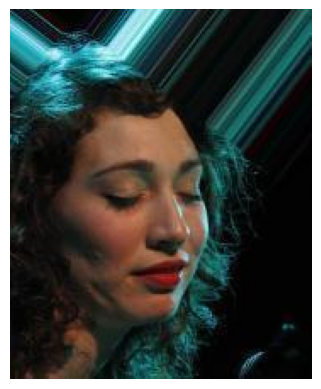

---> No Beard <---
---> Wearing Lipstick <---
---> Young <---


In [62]:
# predicting on test data
predict(r"extracted_images/test_1/182639.jpg")

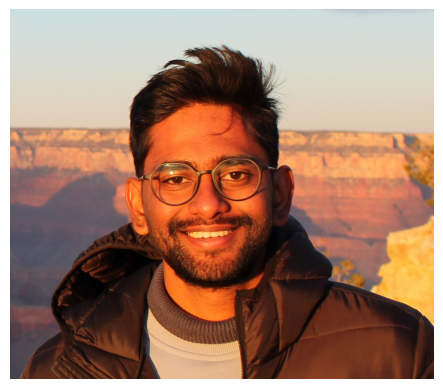

---> Big Nose <---
---> Eyeglasses <---
---> Male <---
---> No Beard <---


In [39]:
# predicting on unseen data
predict(r"extracted_images/unseen_data/bharath.jpg")

In [73]:
def plot_evaluation(train_losses, train_accuracy_scores, val_losses, val_accuracy_scores, precision, recall, f_score):
    """Plot evaluation metrics including training and validation losses, accuracy scores, and precision, recall, and F-score.

    Args:
        train_losses (list): List of training losses.
        train_accuracy_scores (list): List of training accuracy scores.
        val_losses (list): List of validation losses.
        val_accuracy_scores (list): List of validation accuracy scores.
        precision (float): Precision score on the testing data.
        recall (float): Recall score on the testing data.
        f_score (float): F-score on the testing data.
    """
    # subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Losses
    axes[0].plot(train_losses, label='Training Loss', color='orange', marker='o')
    axes[0].plot(val_losses, label='Validation Loss', color='green', marker='o')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Losses vs. Epochs')
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy Scores
    axes[1].plot(train_accuracy_scores, label='Training Accuracy', color='orange', marker='o')
    axes[1].plot(val_accuracy_scores, label='Validation Accuracy', color='green', marker='o')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy Score')
    axes[1].set_title('Training and Validation Accuracy Scores vs. Epochs')
    axes[1].legend()
    axes[1].grid(True)

    # Precision, Recall, F-Score
    metrics = ['Precision', 'Recall', 'F-Score']
    values = [precision, recall, f_score]
    axes[2].bar(metrics, values, color=['orange', 'blue', 'green'])
    axes[2].set_title('Testing Data Precision, Recall, and F-Score')
    axes[2].set_ylabel('Score')
    axes[2].grid(axis='y')
    axes[2].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

In [74]:
file_path = "./model_evaluation/data_resnet.json"

# saving evaluation metrics to a JSON file
with open(file_path, "w") as json_file:
    json.dump(Metric, json_file)

print("Data saved to", file_path)

Data saved to ./model_evaluation/data_resnet.json


Note: In the below cell, the print statement code is not what we wanted to print. Please ignore it!

batch Size = trained/resnet50/attr | learning Rate = classification | num_features = 64 | drop out = 0.01


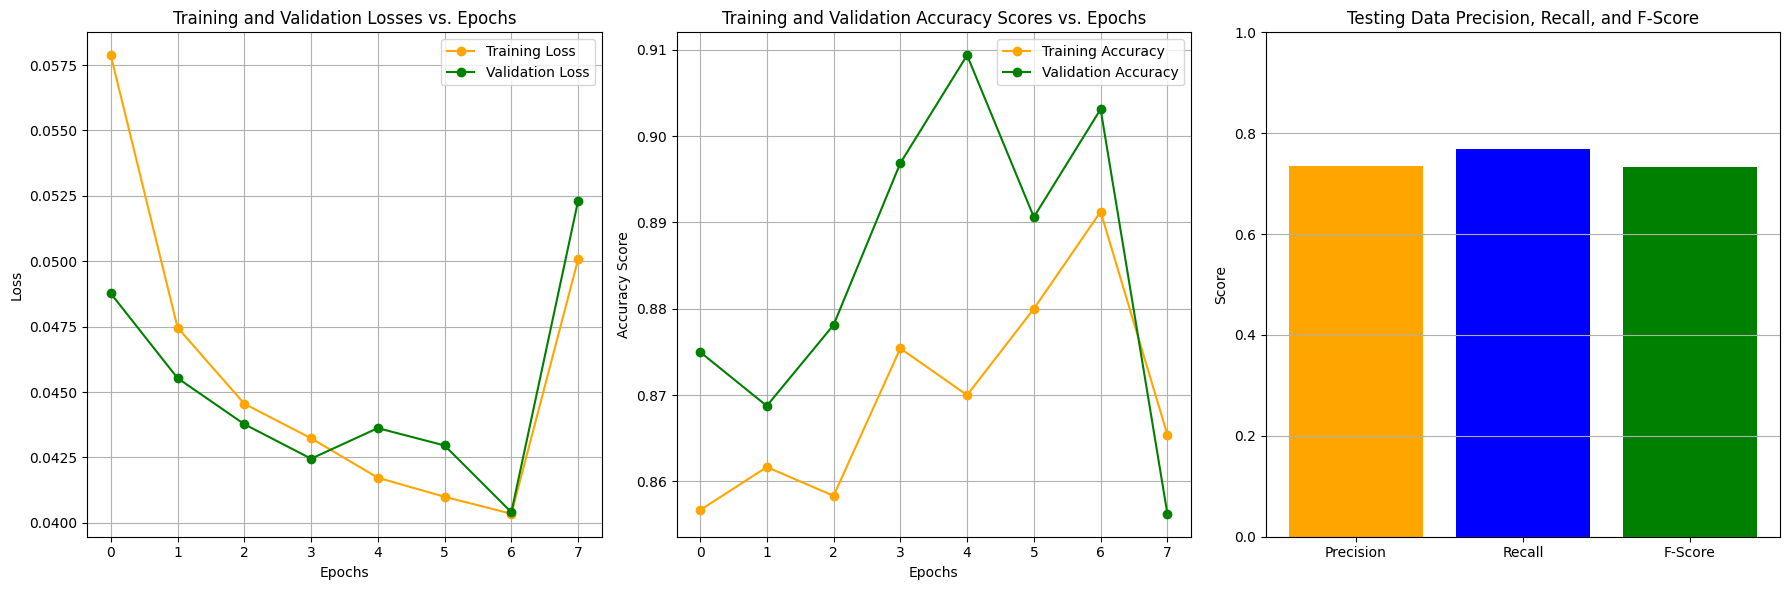

batch Size = trained/resnet50/attr | learning Rate = classification | num_features = 64 | drop out = 0.01


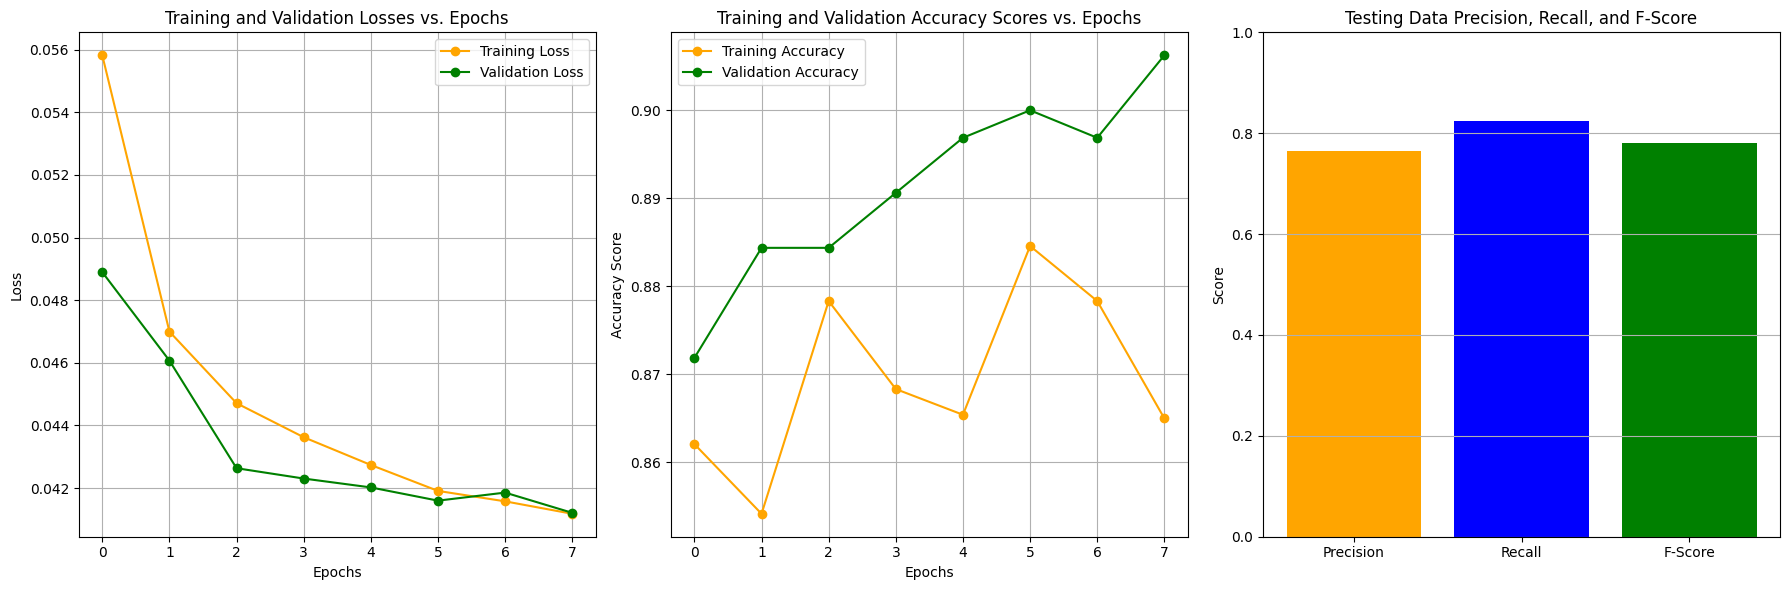

batch Size = trained/resnet50/attr | learning Rate = classification | num_features = 64 | drop out = 0.005


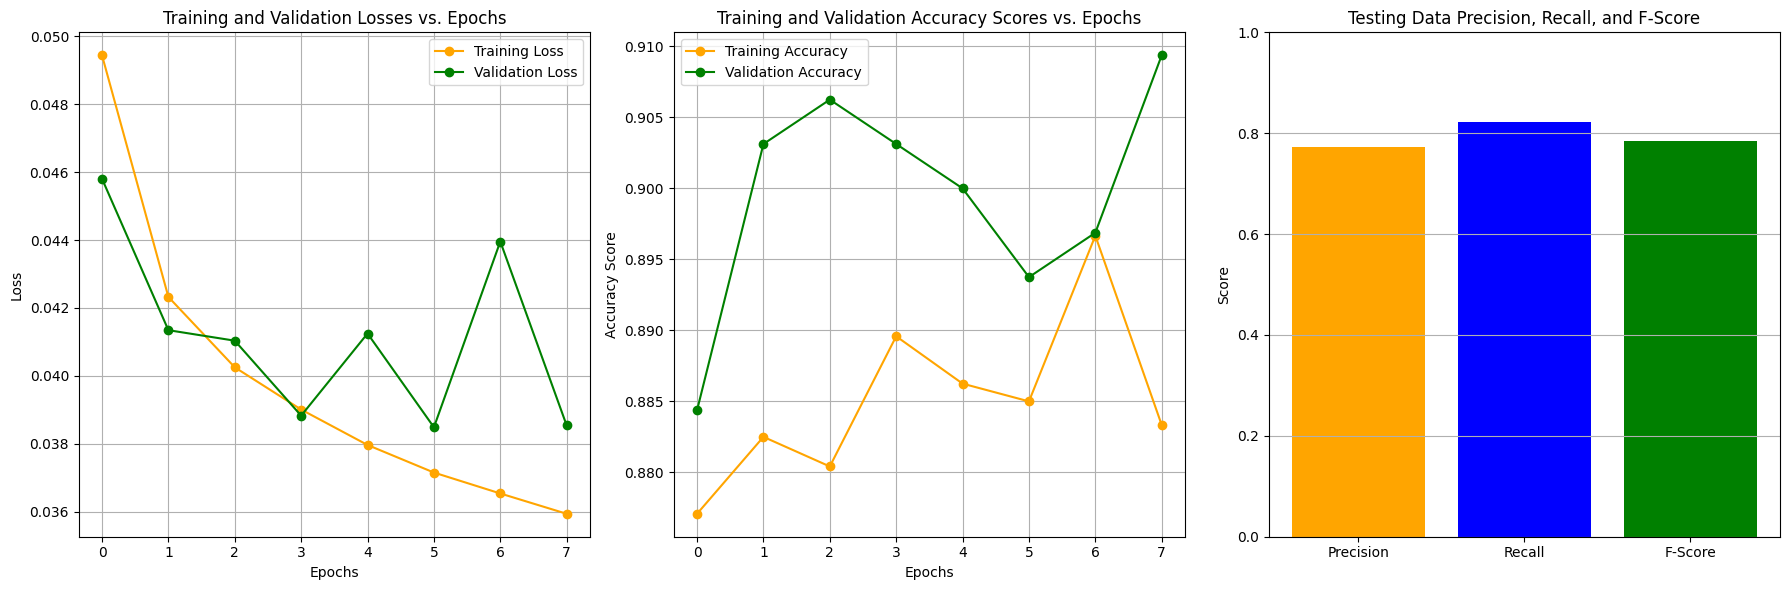

batch Size = trained/resnet50/attr | learning Rate = classification | num_features = 64 | drop out = 0.005


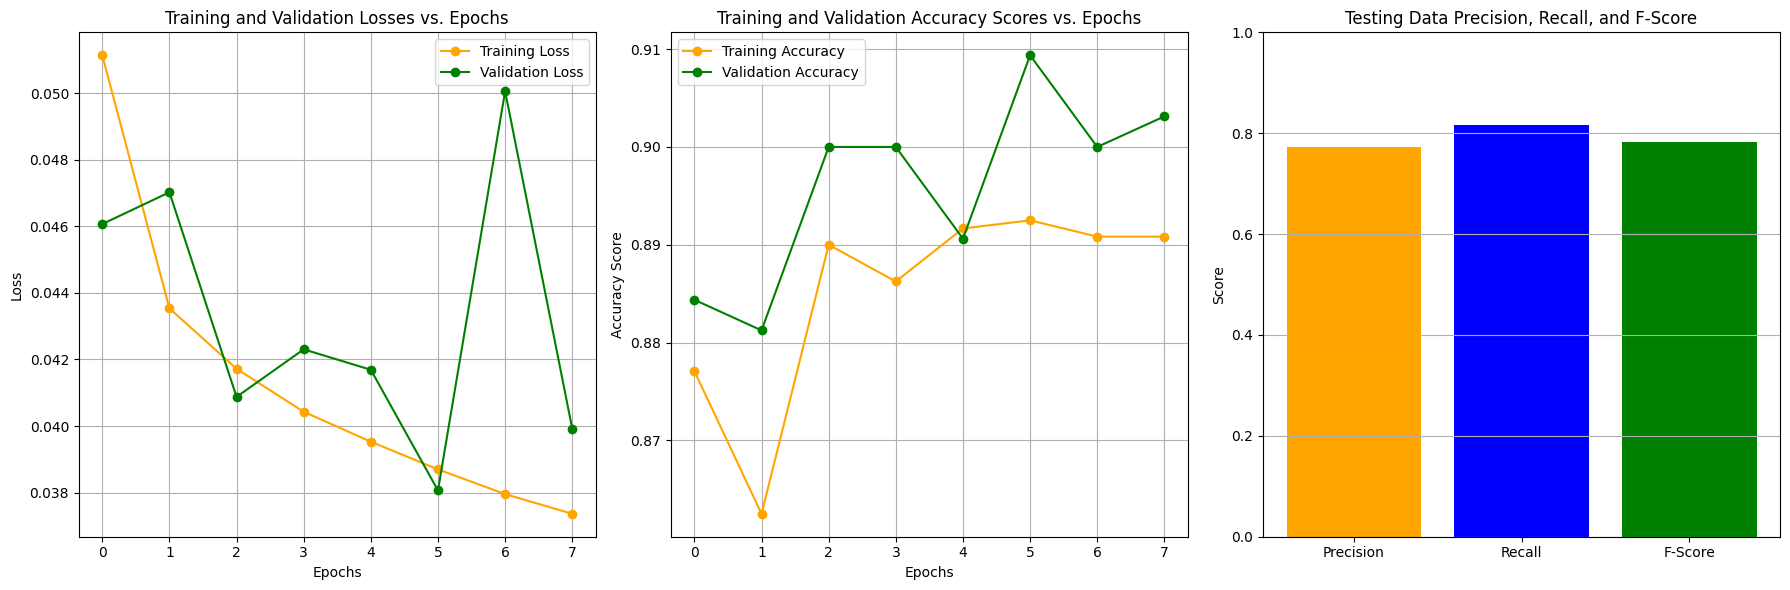

batch Size = trained/resnet50/attr | learning Rate = classification | num_features = 64 | drop out = 0.001


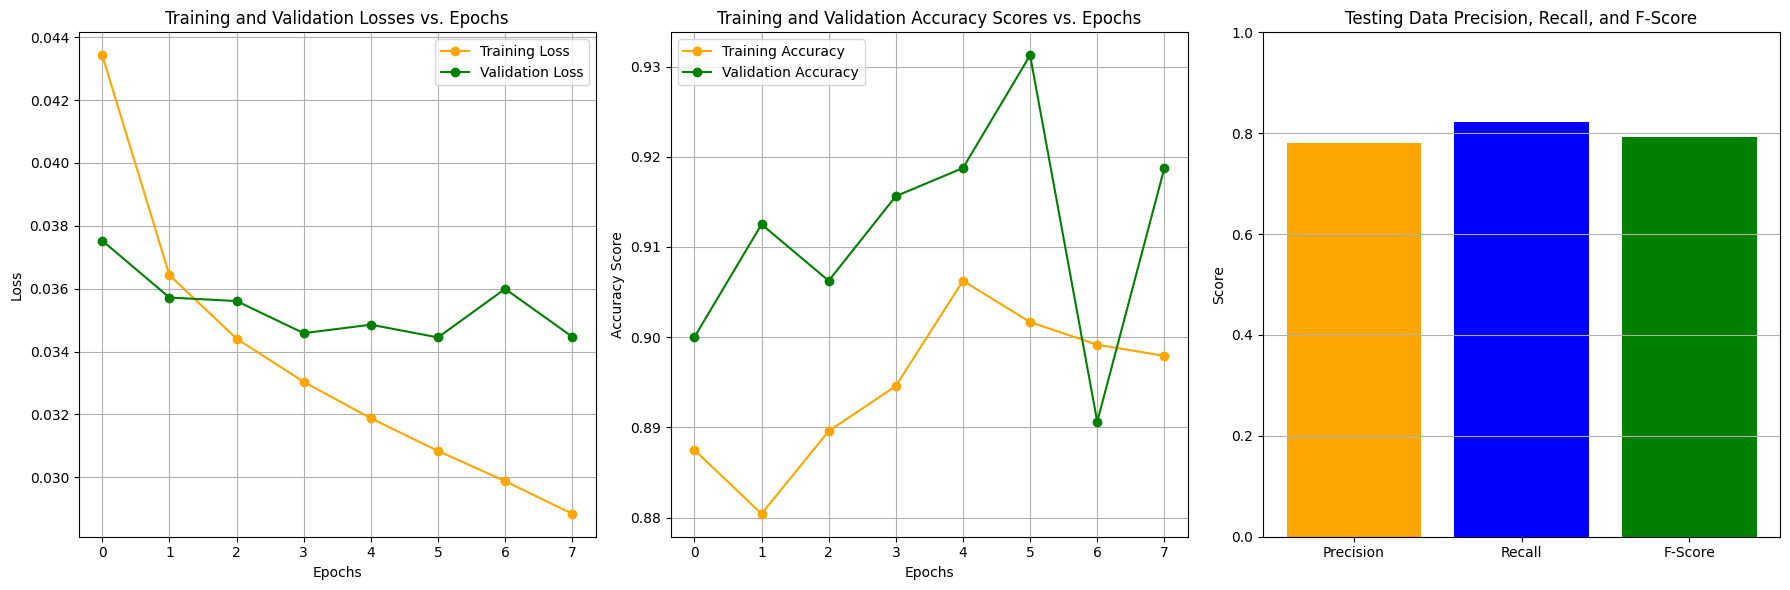

batch Size = trained/resnet50/attr | learning Rate = classification | num_features = 64 | drop out = 0.001


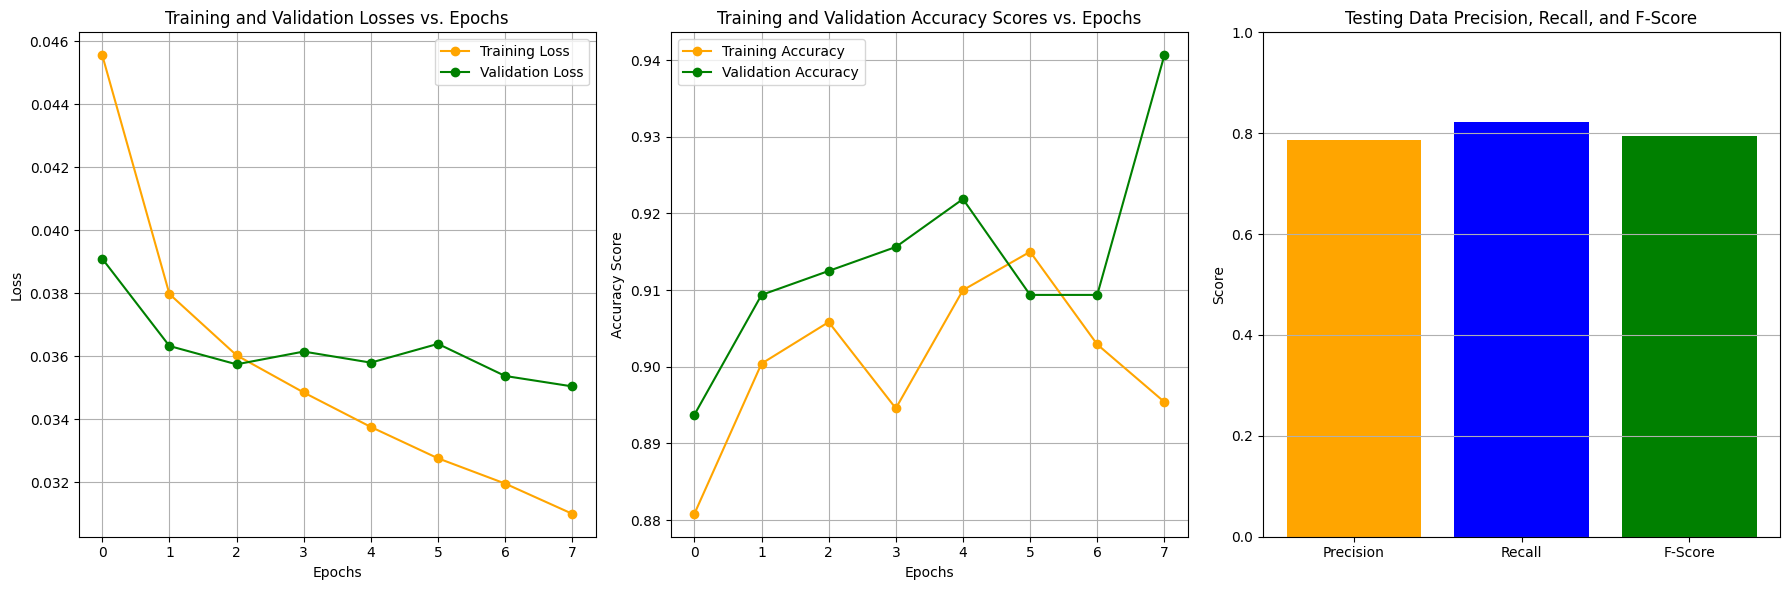

In [75]:
with open('./model_evaluation/data_resnet.json', 'r') as file:
    data = json.load(file)

# names of models from the loaded data
name_models = list(data.keys())

# over each model
for name_ in name_models:
    # parsing hyperparameters from the model name
    parts = name_.split('_')
    batch_size = parts[1]
    learning_rate = parts[2]
    num_features = parts[3]
    dropout = parts[4].replace('.pth','')  # Remove file extension
    print(f'batch Size = {batch_size} | learning Rate = {learning_rate} | num_features = {num_features} | drop out = {dropout}')
    print(f'=============================================================================')
    # evaluation metrics
    train_losses, train_accuracy_scores, val_losses, val_accuracy_scores = data[name_][0]
    precision, recall, f_score = data[name_][1]
    # evaluation metrics
    plot_evaluation(train_losses, train_accuracy_scores, val_losses, val_accuracy_scores, precision, recall, f_score)
    
# Note: In the below cell, the print statement code is not what we wanted to print. Please ignore it!

### **Testing Accuracy**

As suggested at the time of presentation we are getting the metrics for each class

In [45]:
all_predictions, all_targets = get_multilabel_evaluation(Model, test_loader)

# flattening predictions and targets
predictions_flat = [item for sublist in all_predictions for item in sublist]
targets_flat = [item for sublist in all_targets for item in sublist]

# accuracy
accuracy = accuracy_score(targets_flat, predictions_flat)
print("Accuracy:", accuracy)

# classification report for all the classes
report = classification_report(targets_flat, predictions_flat)
print("Classification Report:")
print(report)

Accuracy: 0.89683
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.62      0.62       489
           1       0.69      0.55      0.61      1446
           2       0.78      0.83      0.80      2481
           3       0.57      0.54      0.56       998
           4       0.87      0.62      0.72       115
           5       0.86      0.84      0.85       794
           6       0.71      0.12      0.20      1682
           7       0.56      0.61      0.58      1057
           8       0.79      0.76      0.77      1434
           9       0.86      0.74      0.79       656
          10       0.62      0.18      0.28       256
          11       0.59      0.73      0.65       892
          12       0.64      0.70      0.67       661
          13       0.54      0.42      0.47       291
          14       0.62      0.47      0.53       243
          15       0.95      0.89      0.92       321
          16       0.68      0.67      0

In [54]:
report = classification_report(targets_flat, predictions_flat, output_dict=True)
class_names = celeb_attr.columns[1:]
class_metrics = {}

# metrics for each class from the classification report
for label, metrics in report.items():
    if label.isdigit():
        class_name = class_names[int(label)]  # Map label index to class name
        precision = metrics['precision']
        recall = metrics['recall']
        f1_score = metrics['f1-score']
        class_metrics[class_name] = {'precision': precision, 'recall': recall, 'f1_score': f1_score}

# class-wise metrics to a CSV file
with open('output_metrics/resnet_metrics.csv', 'w', newline='') as csvfile:
    fieldnames = ['label', 'precision', 'recall', 'f1_score', 'class_name']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for label, metrics in class_metrics.items():
        writer.writerow({'label': label, 'precision': metrics['precision'], 'recall': metrics['recall'],
                         'f1_score': metrics['f1_score'], 'class_name': label})